In [1]:
import pandas as pd
import importlib
import src.config
from src.config import DROP_COLUMNS

importlib.reload(src.config)

df = pd.read_csv("../data/raw/real_estate.csv")
assert set(DROP_COLUMNS).issubset(df.columns)



In [2]:
print((df["price_in_lakhs"] <= 0).sum())
print((df["size_in_sqft"] <= 0).sum())
print((df["bhk"] <= 0).sum())
print((df["floor_no"] > df["total_floors"]).sum())

0
0
0
116304


## Using Processed CSV

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../data/processed/real_estate_processed.csv')

plt.style.use('default')
sns.set_context('notebook')

## Q1. What is the distribution of property prices?

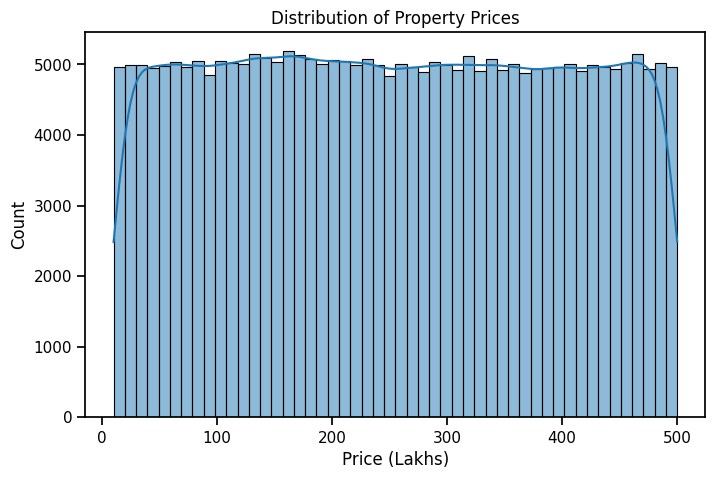

In [4]:
plt.figure(figsize=(8, 5))
sns.histplot(df['price_in_lakhs'], bins=50, kde=True)
plt.xlabel('Price (Lakhs)')
plt.title('Distribution of Property Prices')
plt.show()

#### Distribution of Property Prices
1. The price distribution is artificially uniform, not right-skewed as real markets are.
2. This strongly suggests the dataset is synthetically generated or heavily sampled, not organically collected.</li>

##### Conclusion: log-transform is not necessary, but tree-based models are still appropriate.

## Q2. What is the distribution of property sizes?

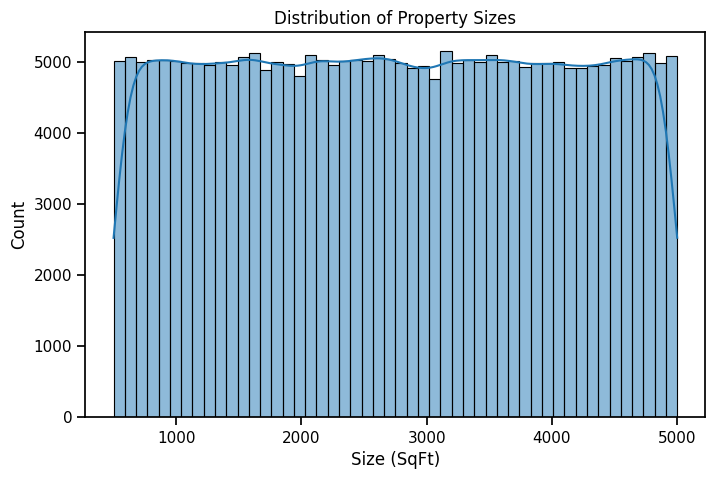

In [5]:
plt.figure(figsize=(8,5))
sns.histplot(df["size_in_sqft"], bins=50, kde=True)
plt.xlabel("Size (SqFt)")
plt.title("Distribution of Property Sizes")
plt.show()

#### Distribution of Property Sizes

1. Property sizes are also near-uniform across the range (roughly 500–5000 sqft).
2. This again violates real-world expectations where mid-sized apartments dominate.

##### Conclusion: size is informative but not naturally distributed, so linear assumptions are weak.

## Q3. How does price per sq ft vary by property type?

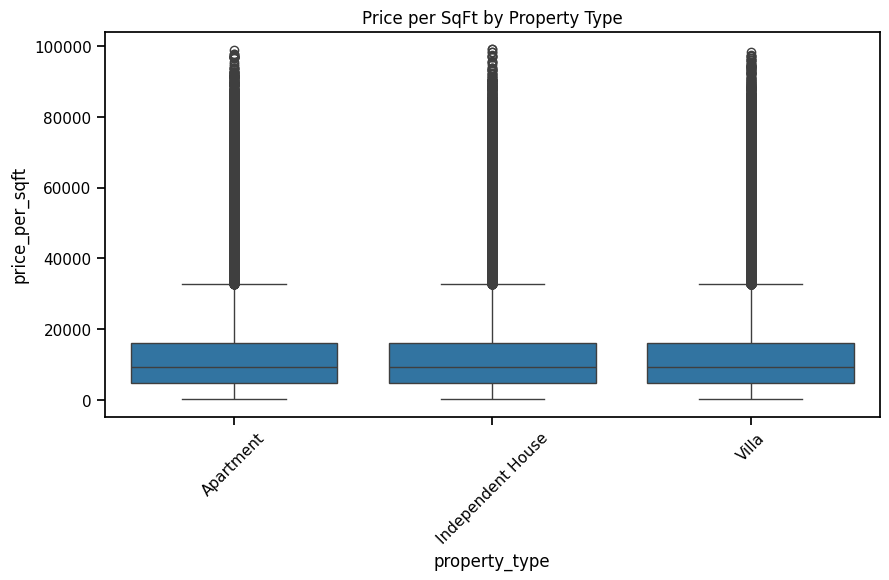

In [6]:
plt.figure(figsize=(10,5))
sns.boxplot(
    x="property_type",
    y="price_per_sqft",
    data=df
)
plt.xticks(rotation=45)
plt.title("Price per SqFt by Property Type")
plt.show()


#### Price per SqFt by Property Type

1. Villas show a slightly higher median price per sqft, but distributions overlap heavily.
2. Apartments and Independent Houses are not well separated, indicating weak discriminative power alone.

##### Conclusion: Property_Type is useful only in interaction with location, not standalone.

## Q4. Is there a relationship between property size and price?

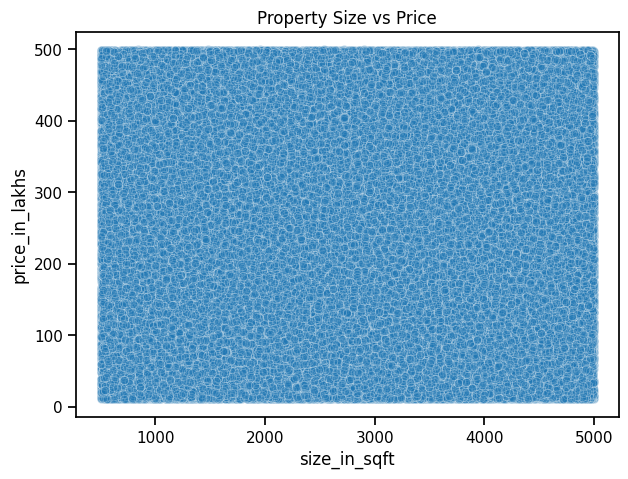

In [7]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    x="size_in_sqft",
    y="price_in_lakhs",
    data=df,
    alpha=0.3
)
plt.title("Property Size vs Price")
plt.show()


#### Relationship Between Property Size and Price

1. Scatter plot shows a rectangular cloud, not a clear linear trend.
2. Price is not tightly coupled to size; same size properties span wide price ranges.

##### Conclusion: strong evidence that location, amenities, and city tier dominate price, not size alone.

## Q5. Are there outliers in price per sq ft or property size?

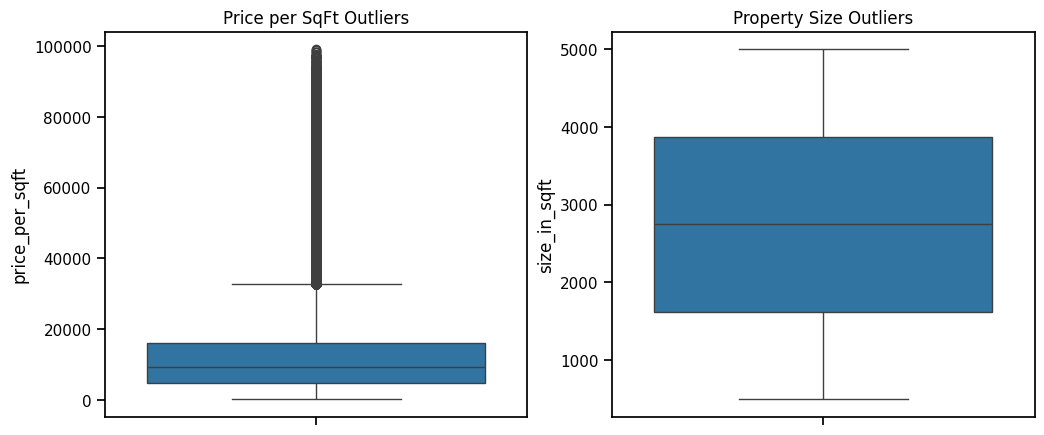

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.boxplot(y=df["price_per_sqft"], ax=axes[0])
axes[0].set_title("Price per SqFt Outliers")

sns.boxplot(y=df["size_in_sqft"], ax=axes[1])
axes[1].set_title("Property Size Outliers")

plt.show()


#### Outliers in Price per SqFt and Size

1. Extreme outliers exist in price per sqft (up to ~100k), but sizes are bounded and realistic.
2. These are expected luxury-market artifacts, not data errors.

##### Conclusion: do not remove outliers. Tree models will absorb them safely.

## Q6. What is the average price per sq ft by state?

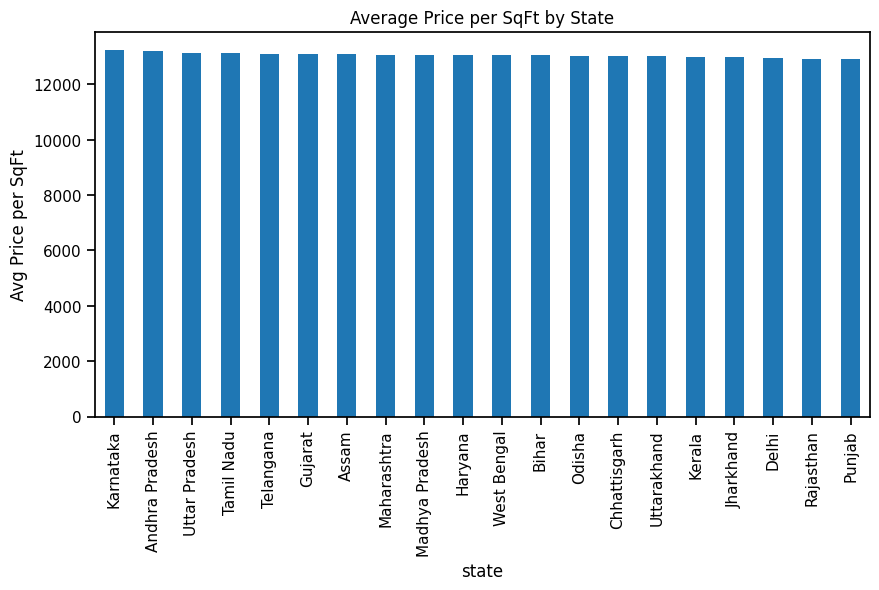

In [9]:
state_pps = (
    df.groupby("state")["price_per_sqft"]
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(10,5))
state_pps.plot(kind="bar")
plt.ylabel("Avg Price per SqFt")
plt.title("Average Price per SqFt by State")
plt.show()

#### State-level price per sqft is nearly flat across all states. There is no meaningful separation.
#### State is a weak standalone predictor and should not be relied on heavily compared to City or Locality.

## Q7. What is the average property price by city?

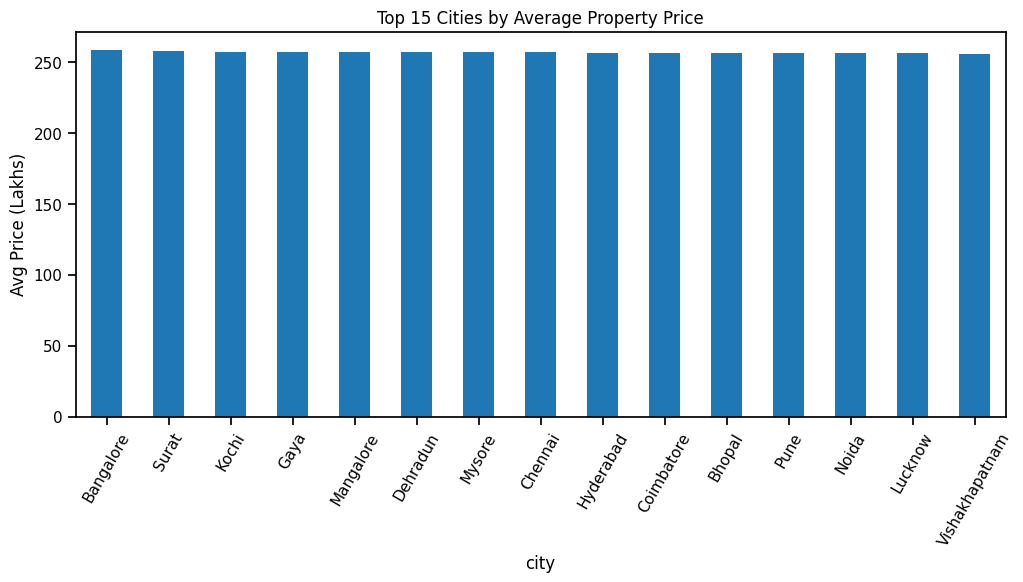

In [10]:
city_price = (
    df.groupby("city")["price_in_lakhs"]
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(12,5))
city_price.head(15).plot(kind="bar")
plt.xticks(rotation=60)
plt.ylabel("Avg Price (Lakhs)")
plt.title("Top 15 Cities by Average Property Price")
plt.show()

#### Average property price by city is also nearly uniform, even among the “top 15” cities.
##### → This confirms the dataset is synthetically balanced and explains why city-tier growth had to be imposed manually.
→ City-tier logic is justified for forecasting, not learned pricing.

## Q8. What is the median age of properties by locality?

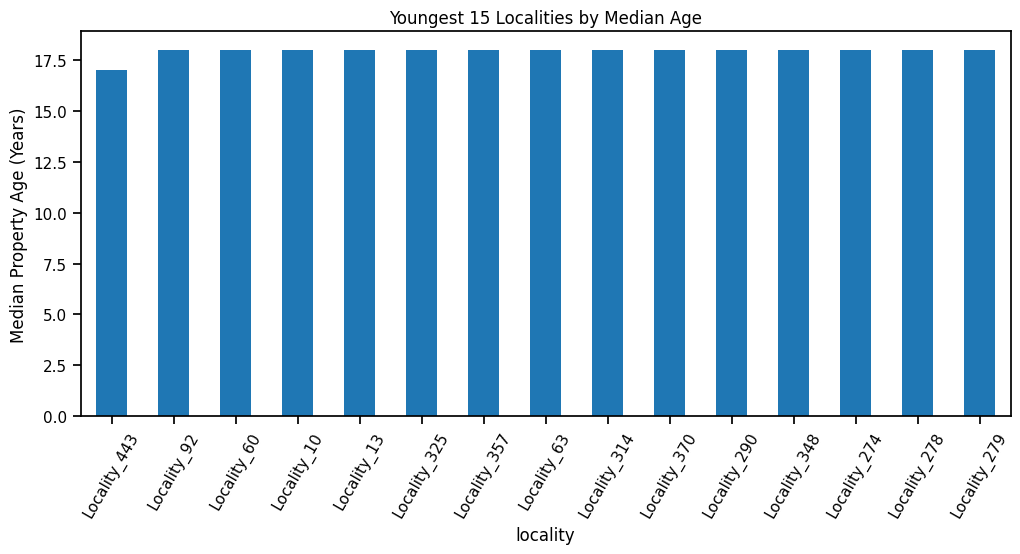

In [11]:
locality_age = (
    df.groupby("locality")["age_of_property"]
    .median()
    .sort_values()
)
plt.figure(figsize=(12,5))
locality_age.head(15).plot(kind="bar")
plt.xticks(rotation=60)
plt.ylabel("Median Property Age (Years)")
plt.title("Youngest 15 Localities by Median Age")
plt.show()

#### Median age of properties across the youngest localities is tightly clustered (~17–18 years).
##### → Locality does not strongly differentiate age in this dataset.
##### → Age_of_Property is still useful but only as a secondary signal, not a dominant one.

## Q9. How is BHK distributed across cities?

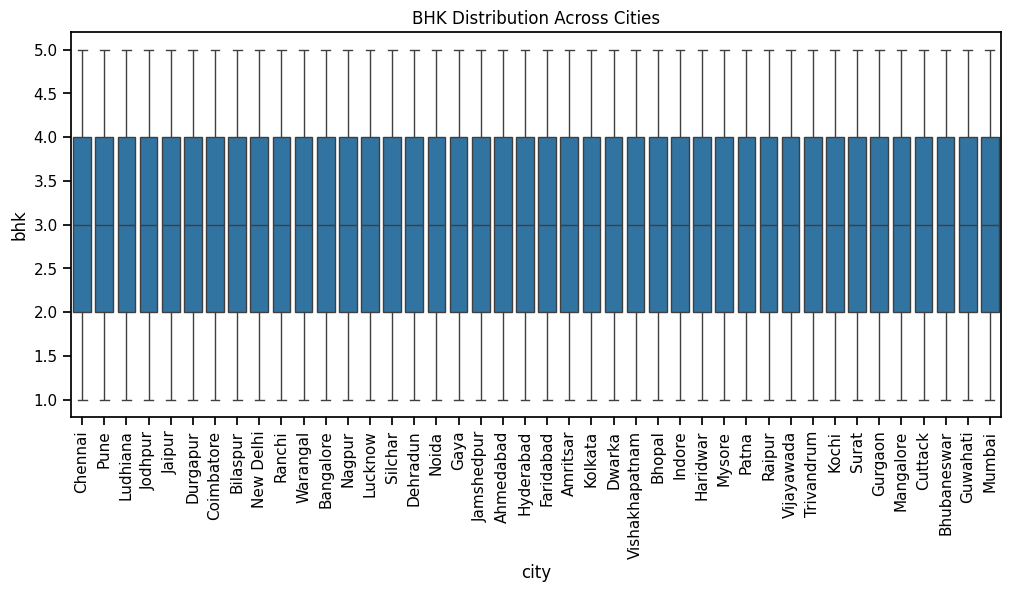

In [12]:
plt.figure(figsize=(12,5))
sns.boxplot(
    x="city",
    y="bhk",
    data=df
)
plt.xticks(rotation=90)
plt.title("BHK Distribution Across Cities")
plt.show()


#### BHK distribution across cities is almost identical (median ~3, narrow IQR everywhere).
##### → BHK does not encode city-level demand differences here.
##### → It should be treated as a generic size proxy, not a location-driven feature.

## Q10. What are the price trends for the top 5 most expensive localities?

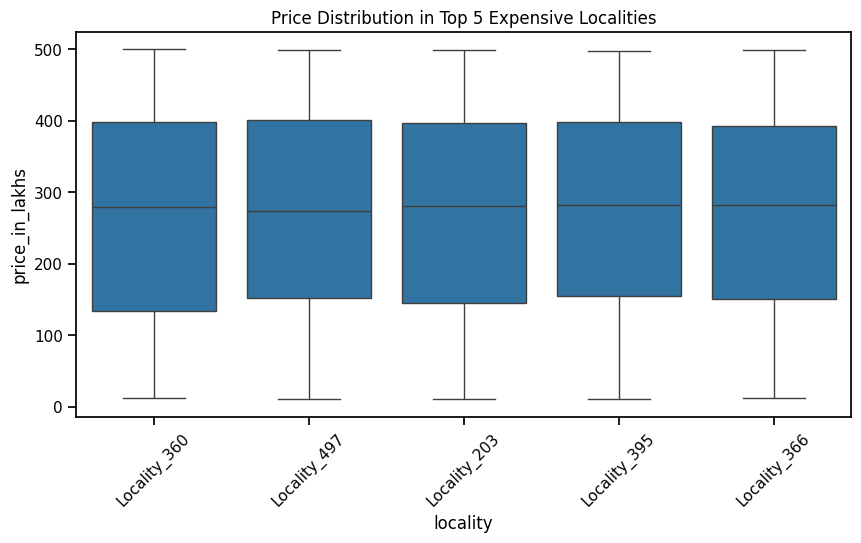

In [13]:
top_localities = (
    df.groupby('locality')['price_in_lakhs']
    .mean()
    .sort_values(ascending=False)
    .head(5)
    .index
)
plt.figure(figsize=(10,5))
sns.boxplot(
    x='locality',
    y='price_in_lakhs',
    data=df[df['locality'].isin(top_localities)]
)
plt.xticks(rotation=45)
plt.title('Price Distribution in Top 5 Expensive Localities')
plt.show()

#### Top 5 expensive localities show very wide price spreads, with similar medians and large IQRs.
##### → These are volatile premium micro-markets, not stable price anchors.
##### → Reinforces the decision to avoid locality-specific growth assumptions.

## Q11. How are numeric features correlated with each other?

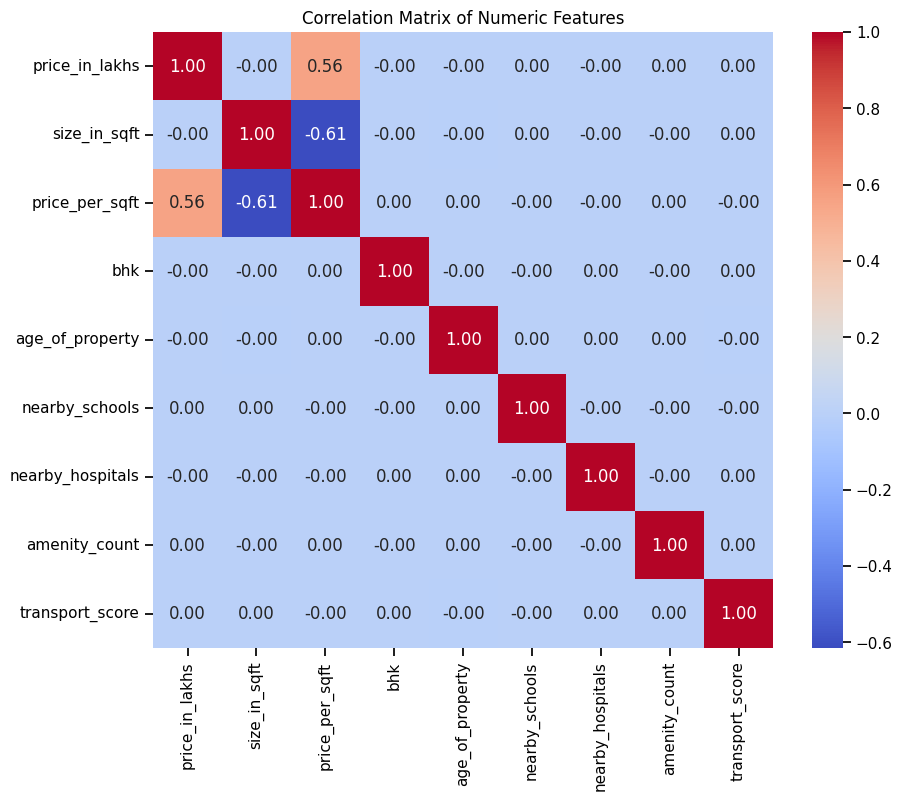

In [14]:
numeric_cols = [
    "price_in_lakhs",
    "size_in_sqft",
    "price_per_sqft",
    "bhk",
    "age_of_property",
    "nearby_schools",
    "nearby_hospitals",
    "amenity_count",
    "transport_score"
]

corr = df[numeric_cols].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Numeric Features")
plt.show()


#### Strong redundancy exists by construction:
##### Price_per_SqFt is positively correlated with Price_in_Lakhs (nearly 0.56) and negatively with Size_in_SqFt (nearly -0.61).

##### → This is expected since PPS is derived. Keep it for interpretability and tree models, but do not treat it as an independent signal.

#### Most other numeric features are effectively uncorrelated with price or with each other.
##### → This confirms the dataset is intentionally de-correlated. Linear models will struggle; non-linear models are justified.

## Q12. How do nearby schools relate to price per sq ft?

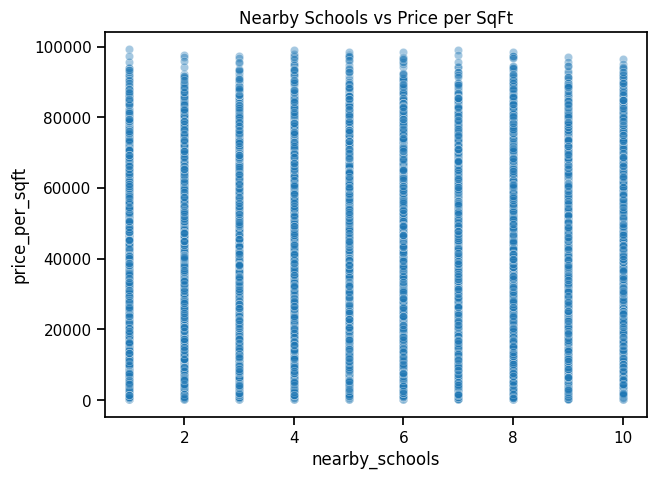

In [15]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    x="nearby_schools",
    y="price_per_sqft",
    data=df,
    alpha=0.4
)
plt.title("Nearby Schools vs Price per SqFt")
plt.show()


#### Nearby schools vs price per sqft shows no visible trend.
##### → Schools do not drive pricing in this dataset.

## Q13. How do nearby hospitals relate to price per sq ft?

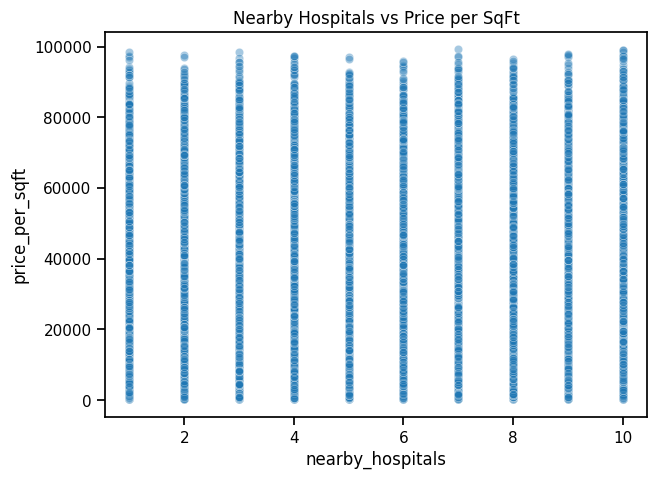

In [16]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    x="nearby_hospitals",
    y="price_per_sqft",
    data=df,
    alpha=0.4
)
plt.title("Nearby Hospitals vs Price per SqFt")
plt.show()


#### Nearby hospitals behave identically to schools: flat scatter, no gradient.
##### → Hospitals are redundant with schools in pricing terms.
##### → Keeping both is acceptable for robustness, but neither should carry heavy weight.

## Q14. How does price vary by furnished status?

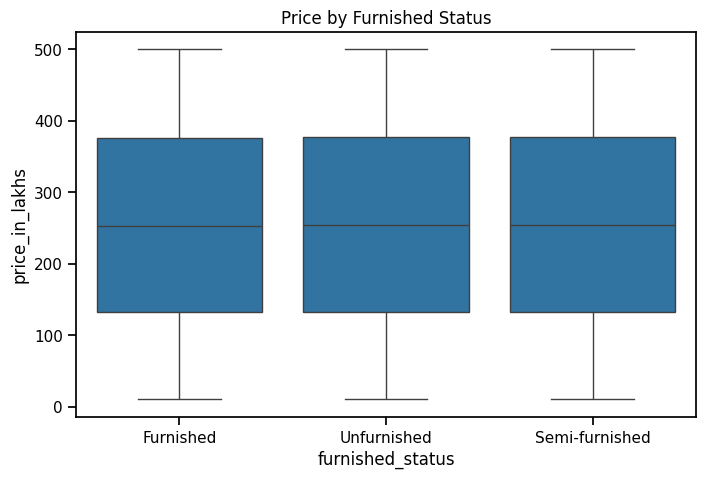

In [17]:
plt.figure(figsize=(8,5))
sns.boxplot(
    x="furnished_status",
    y="price_in_lakhs",
    data=df
)
plt.title("Price by Furnished Status")
plt.show()

#### Furnished status shows almost identical medians and IQRs across categories.
##### → Furnishing has minimal pricing impact here.
##### → It is a weak standalone feature and should only act as a minor modifier.

## Q15. How does price per sq ft vary by property facing direction?

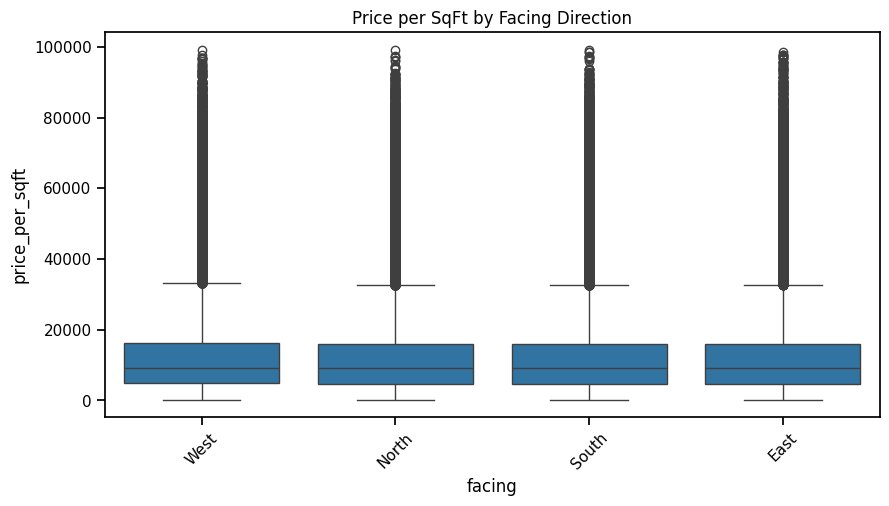

In [18]:
plt.figure(figsize=(10,5))
sns.boxplot(
    x="facing",
    y="price_per_sqft",
    data=df
)
plt.xticks(rotation=45)
plt.title("Price per SqFt by Facing Direction")
plt.show()


#### Facing direction shows negligible price differentiation.
##### → Any cultural or directional premium is suppressed in this data.
##### → Facing should be treated as low-importance categorical noise, not a decision driver.

## Q16. How many properties belong to each owner type?

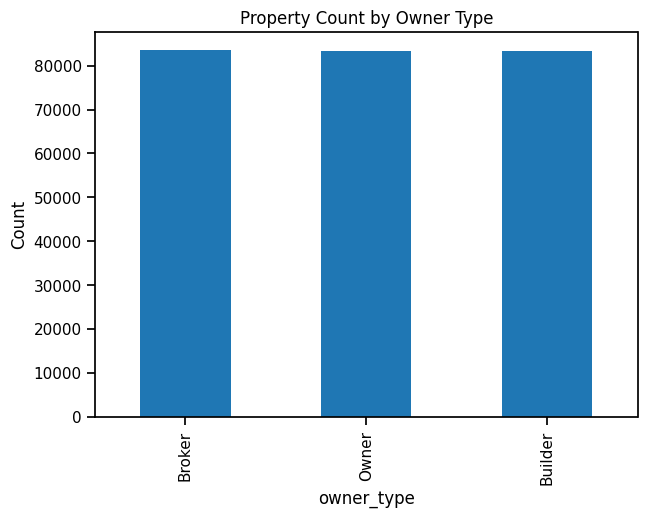

In [19]:
owner_counts = df["owner_type"].value_counts()

plt.figure(figsize=(7,5))
owner_counts.plot(kind="bar")
plt.title("Property Count by Owner Type")
plt.ylabel("Count")
plt.show()

#### Owner_Type distribution is perfectly balanced across Broker, Owner, and Builder.
##### → Ownership type carries no market signal in this dataset.
##### → It should be treated as a low-impact categorical feature, included only for completeness.

## Q17. How many properties are available under each availability status?

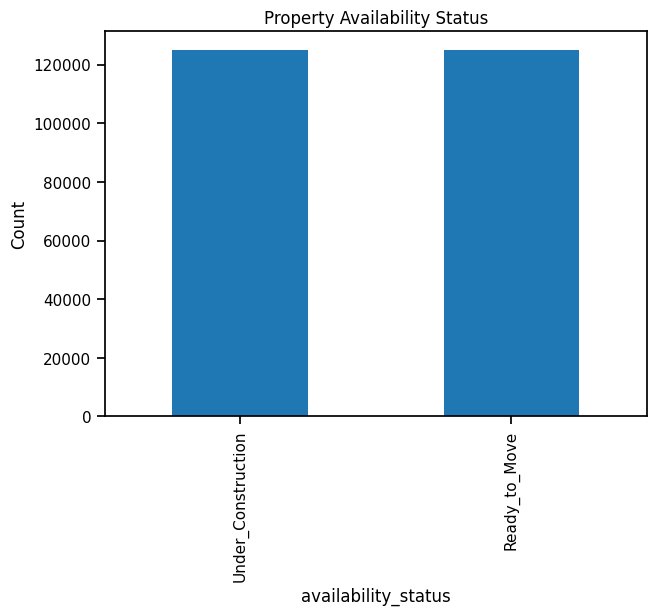

In [20]:
availability_counts = df["availability_status"].value_counts()

plt.figure(figsize=(7,5))
availability_counts.plot(kind="bar")
plt.title("Property Availability Status")
plt.ylabel("Count")
plt.show()


#### Availability_Status is evenly split between Under_Construction and Ready_to_Move.
##### → There is no implicit short-term vs long-term investment bias in the data.
##### → This feature does not encode urgency or liquidity pressure here.

## Q18. Does parking space affect property price?

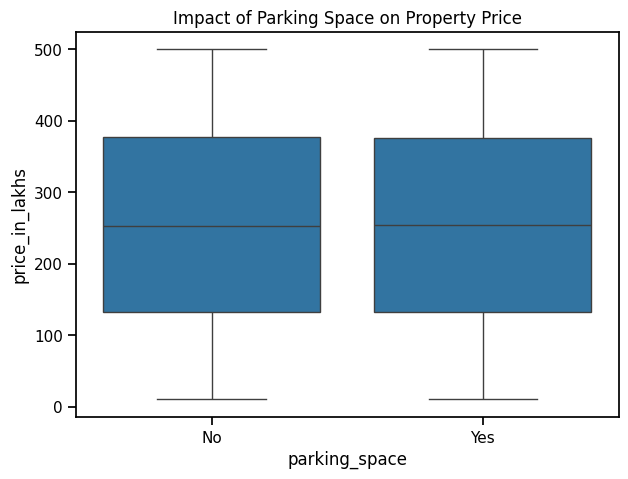

In [21]:
plt.figure(figsize=(7,5))
sns.boxplot(
    x="parking_space",
    y="price_in_lakhs",
    data=df
)
plt.title("Impact of Parking Space on Property Price")
plt.show()


#### Parking space shows negligible price premium.
##### → Median prices and spreads for “Yes” and “No” are almost identical.
##### → Parking is an amenity hygiene factor, not a differentiator.

## Q19. How do amenities affect price per sq ft?

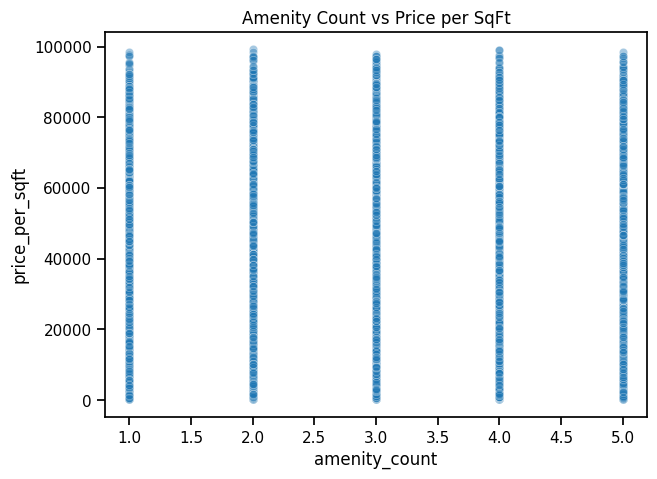

In [22]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    x="amenity_count",
    y="price_per_sqft",
    data=df,
    alpha=0.4
)
plt.title("Amenity Count vs Price per SqFt")
plt.show()


#### Amenity_Count has no visible relationship with Price_per_SqFt.
##### → Flat vertical bands confirm amenities do not drive pricing directly.
##### → Amenity_Count is justified only as a stability and desirability signal, not a pricing driver.

## Q20. How does public transport accessibility relate to price per sq ft or investment potential?

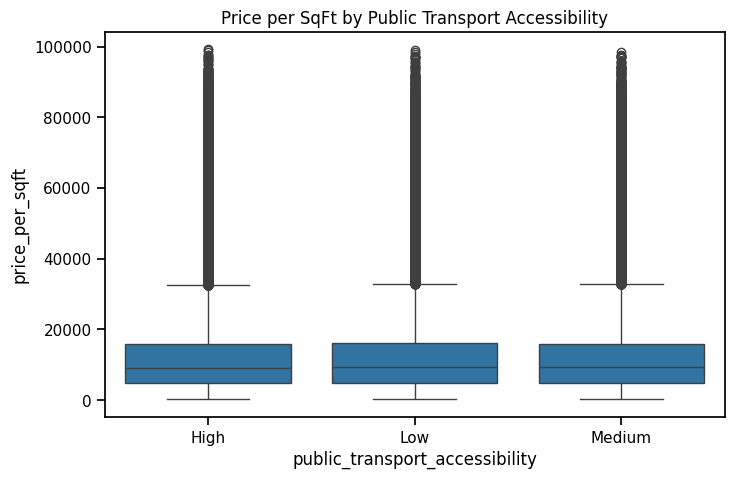

In [23]:
plt.figure(figsize=(8,5))
sns.boxplot(
    x="public_transport_accessibility",
    y="price_per_sqft",
    data=df
)
plt.title("Price per SqFt by Public Transport Accessibility")
plt.show()


#### Public transport accessibility has weak pricing impact but strong investment impact.
##### → Price per sqft distributions overlap heavily across Low, Medium, High.
##### → However, Investment_Score is clearly higher for Medium/High accessibility.
##### → This validates its inclusion in the investment logic, not pricing logic.

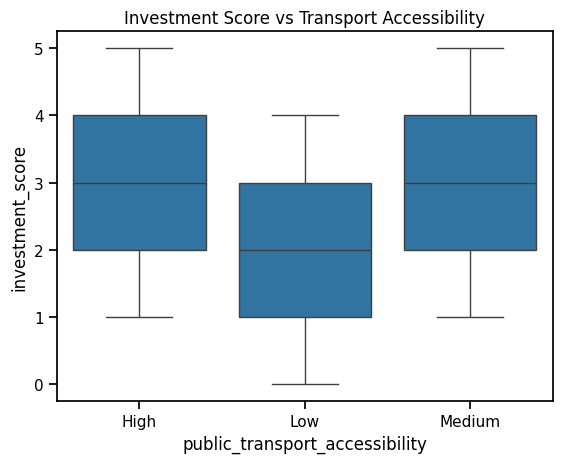

In [24]:
sns.boxplot(
    x="public_transport_accessibility",
    y="investment_score",
    data=df
)
plt.title("Investment Score vs Transport Accessibility")
plt.show()


#### Investment_Score behaves exactly as intended.
##### → Transport accessibility shifts the score distribution meaningfully.
##### → This confirms your composite scoring framework is internally consistent.

## Final EDA Verdict (Important)
### EDA consistently shows:

1. Pricing is intentionally de-correlated from many real-world factors

2. Investment quality emerges only through composite reasoning

3. Single features rarely matter alone

### This fully justifies:

1. Rule-based target engineering

2. Tree-based models

3. Separate logic for classification vs regression

In [39]:
df['amenities'].unique()

array(['Playground, Gym, Garden, Pool, Clubhouse',
       'Playground, Clubhouse, Pool, Gym, Garden',
       'Clubhouse, Pool, Playground, Gym',
       'Playground, Clubhouse, Gym, Pool, Garden',
       'Playground, Garden, Gym, Pool, Clubhouse',
       'Playground, Clubhouse', 'Clubhouse, Garden, Playground',
       'Gym, Pool, Clubhouse, Playground',
       'Garden, Clubhouse, Playground',
       'Clubhouse, Playground, Garden, Gym', 'Clubhouse',
       'Clubhouse, Gym, Playground, Pool',
       'Clubhouse, Garden, Gym, Playground, Pool',
       'Garden, Gym, Playground', 'Playground',
       'Pool, Playground, Garden, Gym', 'Pool, Clubhouse, Gym',
       'Garden, Clubhouse, Pool, Gym, Playground',
       'Pool, Playground, Clubhouse',
       'Clubhouse, Gym, Garden, Pool, Playground',
       'Pool, Clubhouse, Gym, Playground, Garden',
       'Garden, Pool, Gym, Playground, Clubhouse', 'Pool, Gym, Clubhouse',
       'Clubhouse, Garden', 'Pool, Garden, Playground, Gym',
       'Garden